$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# Sample-by-Sample Linear Regression

Also referred to as sequential, on-line, or stochastic gradient descent, training.

Let's say we want to model a set of data points with a linear function.  Call that function $g(\xv; \wv)$, a function of $\xv$ that is parameterized by $\wv$.  

$$
    g(\xv;\wv) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D = \xv^T \wv
$$

The parameter vector $\wv = (w_0, w_1, w_2, \ldots, w_D)$.

Given a bunch of samples of $\xv$ and desired target values of $g(\xv)$, how do we pick values of $\wv$?  We want to pick values of $\wv$ for which $g(\xv;\wv)$ "is close to" the desired target values.  A common approach is to pick values of $\wv$ that minimize the sum of the squared errors, defined by the following equation, where $t_n$ is the target value for input $\xv_n$. 

$$
\begin{align*}
\wv_{\mbox{best}} &= \argmin{\wv} \sum_{n=1}^N (t_n - g(\xv_n ; \wv))^2\\
 & = \argmin{\wv} \sum_{n=1}^N (t_n - \xv_n^T \wv)^2
 \end{align*}
$$

Since the derivative of this sum of squared errors with respect to $\wv$, we can set the derivative equal to zero and solve for $\wv$ to get

$$
      \wv = (X^T X)^{-1} X^T T
$$

where $X$ is a matrix of all input samples as rows, and $T$ is a matrix of all target values as rows.

But what if you have thousands or millions of samples?  $X$ and $T$
can be quite large. To avoid dealing with matrix operations on huge
matrices, we can derive a sequential algorithm for finding $\wv$ by
using the fact that a derivative of a sum is the sum of the
derivatives.

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (t_n - \xv_n^T \wv)^2}{\partial \wv} 
&= 
\sum_{n=1}^N \frac{\partial (t_n - \xv_n^T \wv)^2}{\partial \wv}\\
&= 
\sum_{n=1}^N 2 (t_n - \xv_n^T  \wv) (-1) \xv_n\\
&= -2 \sum_{n=1}^N (t_n - \xv_n^T  \wv) \xv_n\\
\end{align*}
$$

So far this is just another way to write the matrix equation for
$\wv$.  However, instead of summing over all $N$ samples, what if we
just update $\wv$ after each sample based on the derivative of the
squared error for that sample?  The derivative for a sample $n$ can be
considered as a limited, or noisy, sample of the overall derivative.
Thus, we can take a small step in the direction of the negative derivative to try
to bring a current guess at the weight vector, $\wv^{(k)}$, on
iteration $k$ closer to a value that reduces the overall error. In general this kind of update is called "stochastic approximation".

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta (t_n - \xv_n^T  \wv) \xv_n\\
 &= \wv^{(k)} + \eta (t_n - \xv_n^T  \wv) \xv_n
\end{align*}
$$

For this sequential algorithm to converge, $\eta$ must decrease with
each iteration, not too fast but not too slow. 

This algorithm is called the least mean squares (LMS) algorithm
developed by Widrow and Hoff.  It is now often referred to as the
''stochastic gradient descent'' algorithm for linear models.

Let's animate the progress down the derivative.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This approach to animation is modeled after [this notebook](https://nbviewer.jupyter.org/github/WillClaudeHolmes/Jupyter_Examples/blob/master/AnimationIllustration.ipynb).

In [2]:
import IPython.display as ipd

In [3]:
nSamples = 1000
X = np.random.uniform(0,10,(nSamples,1))
T = 2 - 0.1 * X + np.random.normal(0,0.1,(nSamples,1)) + 0.0*(X-6)**2 # Change 0 to 0.05 to try to fit nonlinear cloud

X1 = np.insert(X, 0, 1, axis=1)
# T = ts.reshape((-1,1))

X1.shape, T.shape

((1000, 2), (1000, 1))

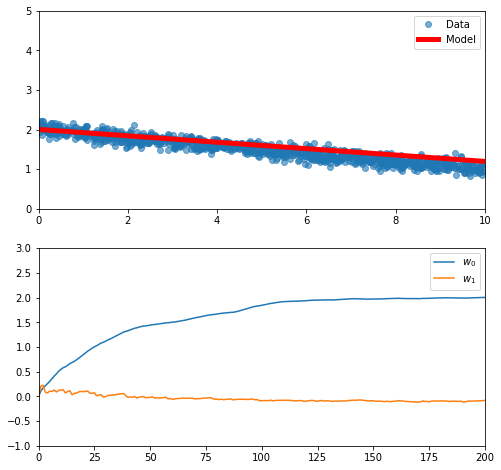

In [4]:
nFrames = 2000
nUpdatesPerFrame = 10
nIterations = nFrames // nUpdatesPerFrame
w = np.zeros((2,1))
ws = [w.copy()]
eta = 0.01
step = 0

fig = plt.figure(figsize=(8, 8))
for step in range(nIterations):
    plt.clf()
    
    for updatei in range(nUpdatesPerFrame):
        step += 1
        n = step % nSamples
 
        
        # ======================== DOWN HERE IS THE WHOLE ALGORITHM, FROM HERE....
        # -------------------- Here is the output of the linear model g(x;w)
        predicted = X1[n:n+1,:] @ w
        # -------------------- Here is the gradient of the sum of squared errors with respect to w
        dEdw = - (T[n:n+1, :] - predicted) * X1[n:n+1,:].T
        # -------------------- Here we take a smallstep in the direction of the negative gradient
        w -= eta * dEdw
        # ========================                             .... TO HERE
        
    ws.append(w.copy())
 
    plt.subplot(2, 1, 1)
    plt.plot(X, T, 'o', alpha=0.6)
    xs = np.linspace(0, 10, 100).reshape((-1,1))
    xs1 = np.insert(xs, 0, 1, axis=1)
    plt.plot(xs, xs1 @ w, 'r-', linewidth=5)  # will use modelLine to update model plot
    plt.legend(('Data','Model'), loc='upper right')
    plt.xlim(0, 10)
    plt.ylim(0, 5)

    plt.subplot(2, 1, 2)
    plt.plot(np.array(ws)[:, :, 0])  # will use to update plot of weights trajectory
    plt.xlim(0, nIterations)
    plt.ylim(-1, 3)
    plt.legend(('$w_0$', '$w_1$'))

    ipd.clear_output(wait=True)
    ipd.display(fig)
    
ipd.clear_output(wait=True)

## Linear Models as Neural Networks

Let's extend the model above just a bit by allowing multiple outputs.  We might want to predict horsepower and acceleration of a car from a set of measurements about the car, like its weight, engine displacement and number of cylinders.

Given $X$ and $T$, find $\wv_k$ that minimizes squared error in
the $k^{th}$ output, then use it to make predictions.
Collect all $\wv_k$ as columns in $\Wv$.
$\tilde{\Xv}$ denotes $\Xv$ with  constant 1 column.  The target value
for the $k^{th}$ output for the $n^{th}$ sample is $t_{n,k}$.

$$
\begin{align*}
  E(\Wv) &= \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - \tilde{\xv}_n^T \wv_k)^2\\
   \Wv &= (\tilde{\Xv}^T \tilde{\Xv})^{-1} \tilde{\Xv}^T \Tv\\
 ~\\
  \Wv &= \begin{bmatrix}
    w_{0,1} & w_{0,2} & \cdots & w_{0,K}\\
    w_{1,1} & w_{1,2} & \cdots & w_{1,K}\\
    \vdots\\
    w_{D,1} & w_{D,2} & \cdots & w_{D,K}
  \end{bmatrix}\\
 ~\\
  \Yv &= \tilde{\Xv} \Wv\\
  ~\\
\tilde{\Xv} & \text{ is } N \times (D+1)\\
\Wv & \text{ is } (D+1) \times K\\
\Yv & \text{ is } N \times K
\end{align*}
$$

The calculation of $y_{n,k} = \tilde{\xv_n} \wv_k$ can be drawn as


<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnlinear.png">


Nice picture, but we can still only learn linear functions of the input.  What if a quadratic, or sine function of the input would fit the data better?  

## Structure of a Two Layer Neural Network

We have just entered the world of neural networks. Models other than linear can be formed by adding another layer of units between the input and the output layer. 

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnTwoLayer.png">

$\;\;\;\; \tilde{\Xv} \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\;\;\;\;\;\;\;\; \Vv \;\;\;\;\;\;\;\;\;\;\;\;$
$ \;\;\; \tilde{\Zv} \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\;\;\;\;\;\;\;\; \Wv \;\;\;\;\;\;\;\;\;\;\;\;$ 
$\; \Yv \;\;\;\;\;\;\;\;\;\;\;\;$

$ N \times (D+1) \;~~$
$(D+1) \times M \;~~$
$ N \times (M+1) \;~~$
$(M+1)\times K \;~~$
$ N \times K$

$$
\begin{align*}
\tilde{\Zv} & = h(\tilde{\Xv} \Vv),\\
\Yv & = \tilde{\Zv} \Wv, \text{ or }\\
\Yv & = \tilde{h}(\tilde{\Xv} \Vv) \Wv 
\end{align*}
$$

The two layers are called the **hidden** and **output** layer.

$h$ is the **activation function** for the units in the hidden layer.

We will be doing gradient descent in the squared error, so want
an $h$ whose derivative doesn't grow out of control as $\vv$ grows, and whose
derivative is easy to calculate.

What about polynomials?

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

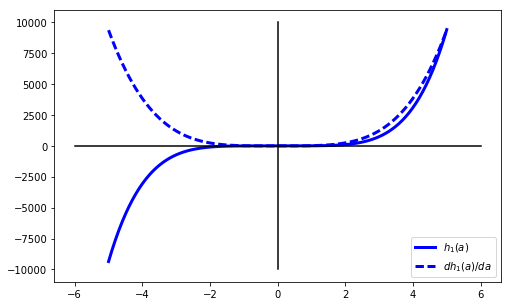

In [6]:
def h(x):
    return 3 + 2 * x + 1 * x**2 + 3 * x**5

def dh(x):
    return 2 + 2 * x + 15 * x**4

plt.figure(figsize=(8,5))
xs = np.linspace(-5,5,100)
plt.plot(xs,h(xs),'b-',linewidth=3, label='$h_1(a)$')
plt.plot(xs,dh(xs),'b--',linewidth=3, label='$d h_1(a)/da$')

plt.plot((-6,6),(0,0),'k')
plt.plot((0,0),(-10000,10000),'k')
plt.plot([0,0],[-1,1],'r--',linewidth=3,alpha=0.5,)
plt.legend(loc='best');

A gradient descent procedure takes steps of size proportional to the derivative.  This derivative gets huge---high positive as $a$ increases and high negative as $a$ decreases---so gradient descent if very unstable.  Such huge steps will shoot the gradient descent far away from a close local minimum.

Two common choices for functions with well-behaved derivatives are, where $a = \tilde{\xv}^T \vv$:
  * sigmoid (asymmetric)
  
$$
        \begin{align*}
          h_1(a) & = \frac{1}{1+e^{-a}}
        \end{align*}
$$

  * tanh (symmetric)
  
$$
        \begin{align*}
          h_2(a) & = \tanh(a) = \frac{e^{a} - e^{-a}}{e^{a} + e^{-a}}
        \end{align*}
$$

Try to derive the derivatives of these functions with respect to $a$.

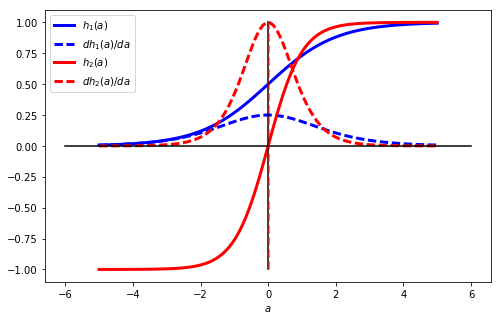

In [7]:
def h1(a):
    return 1 / (1 + np.exp(-a))

def h2(a):
    return np.tanh(a)

def dh1(a):
    y = h1(a)
    return y * (1 - y)

def dh2(a):
    y = h2(a)
    return 1 - y*y

plt.figure(figsize=(8,5))
xs = np.linspace(-5, 5, 100)
plt.plot(xs, h1(xs), 'b-', linewidth=3, label='$h_1(a)$')
plt.plot(xs, dh1(xs), 'b--', linewidth=3, label='$d h_1(a)/da$')

plt.plot(xs, h2(xs), 'r-', linewidth=3, label='$h_2(a)$')
plt.plot(xs, dh2(xs), 'r--', linewidth=3, label='$d h_2(a)/da$')

plt.plot((-6, 6), (0, 0), 'k')
plt.plot((0, 0), (-1, 1), 'k')
plt.plot([0, 0], [-1, 1], 'r--', linewidth=3, alpha=0.5)

plt.xlabel('$a$')
plt.legend(loc='best');

Notice that as the weights increase in magnitude, the argument $a$ to these functions increases in magnitude and you move far left or far right on the x axis.  What happens to the derivatives out there?

## Training by Gradient Descent

The mean squared error between each target value $t_{n,k}$ and
output (predicted) value $y_{n,k}$ is

$$
\begin{align*}
  E &= \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K ( t_{n,k} - y_{n,k})^2
\end{align*}
$$

Since the gradient of $E$ is no longer a linear function of the parameters (weights), we cannot set the derivative equal to zero and solve for the parameters.  Instead, we can do 
gradient descent in $E$ by making small changes to weights $v_{j,m}$ and $w_{m,k}$ in the negative gradient direction. 

$$
\begin{align*}
  v_{j,m} &\leftarrow v_{j,m} - \rho_h \frac{\partial E}{\partial v_{j,m}}\\
  w_{m,k} &\leftarrow w_{m,k} - \rho_o \frac{\partial E}{\partial w_{m,k}}
\end{align*}
$$

This is often presented as $\rho_h = \rho_o$, but having different
rates in the two layers often helps convergence rate.

Will this find the global optimum (the values of $v$ and $w$
that minimize the mean squared error)?

So, now how do we calculate $\frac{\partial E}{\partial v_{j,m}}$ and $\frac{\partial E}{\partial w_{m,k}}$?

### First a Simplified View

Remember our picture of a full two-layer network?  Let's focus
on how to modify a single weight, $v_{1,1}$, based on a single error between $y_1$ and $t_1$.

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnTwoLayerTargetsOnePath.png">

Let's drop the subscripts for now.

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnOnePath.png">

Forward calculation (ignoring constant 1 input and all other terms)

$$
\begin{align*}
  y &= w\; h(v\;x) \text{ or }\\
  y &= w\; z\\
  z &= h(a)\\
  a &= v\; x
\end{align*}
$$

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnOnePath2.png">

Since $E = (t - y)^2$

$$
\begin{align*}
  \frac{\partial E}{\partial v} & = \frac{\partial (t - y)^2}{\partial v}
\end{align*}
$$

The Chain Rule to the rescue.

$$
\begin{align*}
  \frac{\partial E}{\partial v} & = \frac{\partial (t-y)^2}{\partial v}\\
  & = \frac{\partial (t-y)^2}{\partial y} \frac{\partial y}{\partial z} \frac{\partial z}{\partial a} \frac{\partial a}{\partial v} \\
  & = 2(t-y) \;\;(-1)\;\; w \;\;  \frac{\partial h(a)}{\partial a} \;\; x \\
\end{align*}
$$

If $h(a) = \tanh(a)$, then $\frac{\partial h(a)}{\partial a} = (1-h(a)^2) = (1-z^2)$. See [this page at Mathematics Stack Exchange](http://math.stackexchange.com/questions/741050/hyperbolic-functions-derivative-of-tanh-x).

$$
\begin{align*}
  \frac{\partial E}{\partial v} & = -2(t-y) \;\; w \;\;  \frac{\partial h(a)}{\partial a} \;\; x \\
  & = -2(t-y) \;\; w \;\;  (1-z^2) \;\; x
\end{align*}
$$

Let's add another output.

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnTwoPath.png">

The Chain Rule again.

$$
       \begin{align*}
       \frac{\partial E}{\partial v} & = \frac{\partial (t_1-y_1)^2 + (t_2-y_2)^2}{\partial v}\\
       & = \frac{\partial (t_1-y_1)^2 + (t_2-y_2)^2}{\partial z} \frac{\partial z}{\partial a} \frac{\partial a}{\partial v} \\
       & = \left ( \frac{\partial (t_1-y_1)^2 + (t_2-y_2)^2}{\partial y_1}\frac{\partial y_1}{\partial z} + \frac{\partial (y_1-t_1)^2 + (y_2-t_2)^2}{\partial y_2}\frac{\partial
           y_2}{\partial z} \right )  \frac{\partial z}{\partial a} \frac{\partial a}{\partial v} \\
       & = \left ( -2(t_1-y_1) w_1 - 2(t_2 -y_2) w_2 \right ) \frac{\partial z}{\partial a} \frac{\partial a}{\partial v} \\
       & = -2 \left ( (t_1-y_1) w_1 + (t_2-y_2) w_2 \right ) \frac{\partial h(a)}{\partial a} x \\
       & = -2 \left ( (t_1-y_1) w_1 + (t_2-y_2) w_2 \right ) (1-z^2) x 
       \end{align*}
$$

Think of the errors calculated in the output units as being sent backwards to the units in the previous layer.  If we label these errors as "delta" values, our derivative expressions form what are commonly referred to as "delta rules".  The delta values are "backpropagated" to the previous layer.  This process is called "error backpropagation", but is really just the chain rule of calculating derivatives!

First, remember these derivatives.

$$
       \begin{align*}
       \frac{\partial E}{\partial v} & = -2 ( (t_1-y_1) w_1 + (t_2-y_2) w_2  ) (1-z^2) x \\
       \frac{\partial E}{\partial w_1} & = -2 (t_1-y_1) z
       \end{align*}
$$

Now the update rules involving the deltas ($\delta$) are 

$$
       \begin{align*}
       w &\leftarrow w - \frac{\partial E}{\partial w_1}\\
       &\leftarrow w + \rho_o  (t_1-y_1) z\\
       &\leftarrow w + \rho_o  \delta_1^{(o)}  z\\
       v & \leftarrow v - \frac{\partial E}{\partial v}\\
       & \leftarrow v + \rho_h \left ( (t_1-y_1) w_1 + (t_2-y_2) w_2 \right ) (1-z^2) x \\
       & \leftarrow v + \rho_h \left ( (t_1-y_1) w_1 + (t_2-y_2) w_2 \right ) (1-z^2) x \\
       & \leftarrow v + \rho_h \left ( \delta_1^{(o)} w_1 + \delta_2^{(o)} w_2 \right ) (1-z^2) x \\
       & \leftarrow v + \rho_h \delta^{(h)} x\\
&\;\;\; \text{ where } \delta^{(h)} =  ( \delta_1^{(o)} w_1 + \delta_2^{(o)} w_2  ) (1-z^2)
       \end{align*}
$$

### Now for the Full Version of Error Back-Propagation

<img src="http://www.cs.colostate.edu/~anderson/cs440/notebooks/nnTwoLayerBackProp.png">

$$
\begin{align*}
  v_{j,m} &\leftarrow v_{j,m} - \rho_h \frac{\partial E}{\partial
    v_{j,m}}\\
 w_{m,k} & \leftarrow w_{m,k} - \rho_o \frac{\partial E}{\partial w_{m,k}}
\end{align*}
$$

A bit of calculus and algebra lead us to these expressions for doing gradient descent.  Try to derive it yourself!!

$$
\begin{align*}
  v_{j,m} &\leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - y_{n,k}) w_{m,k} (1-\tilde{z}_m^2) \tilde{x}_{n,j}\\
  w_{m,k} &\leftarrow w_{m,k} + \rho_o \frac{1}{N}  \frac{1}{K} \sum_{n=1}^N
  (t_{n,k} - y_{n,k}) \tilde{z}_m
\end{align*}
$$

To summarize:

$$
    \begin{align*}
      E &= \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - y_{n,k})^2\\
      \frac{\partial E}{\partial w_{m,k}} & = -2 \frac{1}{N}  \frac{1}{K}
       \sum_{n=1}^N (t_{n,k} - y_{n,k}) \tilde{z}_{n,m}\\
      \frac{\partial E}{\partial v_{j,m}} & = -2 \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - y_{n,k})   w_{m,k} (1-z_{n,m}^2) \tilde{x}_{n,j}
    \end{align*}
$$

Forward pass

$$
    \begin{align*}
      z_{n,m} &= h(\sum_{j=0}^D v_{j,m} \tilde{x}_{n,j})\\
      y_{n,k} &= \sum_{m=1}^M w_{m,k} \tilde{z}_{n,m}
    \end{align*}
$$

Backward pass

$$
\begin{align*}
      v_{j,m} & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - y_{n,k})   w_{m,k} (1-z_{n,m}^2) \tilde{x}_{n,j}\\
 w_{m,k} & \leftarrow w_{m,k} + \rho_o \frac{1}{N}  \frac{1}{K}  \sum_{n=1}^N (t_{n,k} - y_{n,k}) \tilde{z}_{n,m}
    \end{align*}
$$

## Preparing for Python

Convert these scalar expressions to matrix expressions.

Forward Pass

$$
    \begin{align*}
      z_{n,m} &= h(\sum_{j=0}^D v_{j,m} \tilde{x}_{n,j})\\
      z_{n,m} &= h( v_{*,m} \tilde{x}_{n,*})\\
      z_{n,m} &= h(  \tilde{x}_{n,*} v_{*,m})\\
      z_{*_n,m} &= h(  \tilde{x}_{*_n,*} v_{*,m})\\
      z_{*_n,*_m} &= h(  \tilde{x}_{*_n,*} v_{*,*_m})\\
      \Zv &= h(\tilde{\Xv} \Vv)\\
      y_{n,k} &= \sum_{m=1}^M w_{m,k} \tilde{z}_{n,m}\\
      y_{n,k} &=  \tilde{z}_{n,*} w_{*,k}\\
      y_{*_n,*_k} &=  \tilde{z}_{*_n,*} w_{*,*_k}\\
      \Yv &= \tilde{\Zv} \Wv
    \end{align*}
$$

Backward Pass for $\Vv$

$$
    \begin{align*}
      v_{j,m} & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \sum_{n=1}^N \sum_{k=1}^K (t_{n,k} - y_{n,k})   w_{m,k} (1-z_{n,m}^2) \tilde{x}_{n,j}\\
      v_{j,m} & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \sum_{n=1}^N  (t_{n,*_k} - y_{n,*_k}) w_{m,*_k}^T   (1-z_{n,m}^2) \tilde{x}_{n,j}\\
      v_{j,m} & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \left ( (t_{*_n,*_k} - y_{*_n,*_k}) w_{m,*_k}^T \cdot  (1-z_{*_n,m}^2) \dimensionbar{N\times m} \right )^T
      \tilde{x}_{*_n,j} 
\end{align*}
$$

Almost.  Result on right hand side has subscripts $m,j$, but left side is $j,m$. So

$$
    \begin{align*}
      v_{j,m} & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \left ( \left ( (t_{*_n,*_k} - y_{*_n,*_k}) w_{m,*_k}^T \cdot  (1-z_{*_n,m}^2) \right )^T
      \tilde{x}_{*_n,j} \right )^T\\
       & \leftarrow v_{j,m} + \rho_h \frac{1}{N} \frac{1}{K} \tilde{x}_{*_n,j}^T \left ( (t_{*_n,*_k} - y_{*_n,*_k}) w_{m,*_k}^T \cdot  (1-z_{*_n,m}^2) \right )\\
       v_{*_j,*_m} & \leftarrow v_{*_j,*_m} + \rho_h \frac{1}{N} \frac{1}{K} \tilde{x}_{*_n,*_j}^T \left ( (t_{*_n,*_k} - y_{*_n,*_k}) w_{*_m,*_k}^T \cdot  (1-z_{*_n,*_m}^2)
       \right )\\
       \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \left ( (\Tv - \Yv) \hat{\Wv}^T \cdot  (1-\Zv^2) \right )\\
       \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \dimensionbar{D\times N} \left ( (\Tv - \Yv) \dimensionbar{N\times K} \hat{\Wv}^T \dimensionbar{N\times M} \cdot  (1-\Zv^2)
         \dimensionbar{N\times M}\right ) \dimensionbar{D\times M}\\
       \text{where } & \hat{\Wv} \text{ is } \Wv \text{ without constant input row}
\end{align*}
$$


Backward Pass for $\Wv$

$$
    \begin{align*}
      w_{m,k} & \leftarrow w_{m,k} + \rho_o \frac{1}{N}  \frac{1}{K} \sum_{n=1}^N (t_{n,k} - y_{n,k}) \tilde{z}_{n,m}\\
      & \leftarrow w_{m,k} + \rho_o \frac{1}{N}  \frac{1}{K} (t_{*_n,k} - y_{*_n,k})^T \tilde{z}_{*_n,m}
    \end{align*}
$$

Again, almost.  Result on right hand side has subscripts $k,m$ but need $m,k$. So

$$
    \begin{align*}
      w_{m,k} & \leftarrow w_{m,k} + \rho_o \frac{1}{N} \frac{1}{K}   \left ( (t_{*_n,k} - y_{*_n,k})^T \tilde{z}_{*_n,m} \right )^T\\
       & \leftarrow w_{m,k} + \rho_o \frac{1}{N} \frac{1}{K} \tilde{z}_{*_n,m}^T (t_{*_n,k} - y_{*_n,k}) \\
      w_{*_m,*_k} & \leftarrow w_{*_m,*_k} + \rho_o \frac{1}{N} \frac{1}{K}  \tilde{z}_{*_n,*_m}^T (t_{*_n,*_k} - y_{*_n,*_k}) \\
      \Wv & \leftarrow \Wv + \rho_o \frac{1}{N} \frac{1}{K}  \tilde{\Zv}^T (\Tv - \Yv)\\
      \Wv & \leftarrow \Wv + \rho_o \frac{1}{N} \frac{1}{K}  \tilde{\Zv}^T \dimensionbar{M\times N} (\Tv - \Yv \dimensionbar{N\times K}) \dimensionbar{M\times K}
    \end{align*}
$$

All together now, first in math.

$$
    \begin{align*}
      \Zv &= h(\tilde{\Xv} \Vv)\\
      \Yv &= \tilde{\Zv} \Wv\\
       \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \left ( (\Tv - \Yv) \hat{\Wv}^T \cdot  (1-\Zv^2) \right )\\
      \Wv & \leftarrow \Wv + \rho_o \frac{1}{N}  \frac{1}{K}\tilde{\Zv}^T (\Tv - \Yv)
      \end{align*}
$$

Now in python.

    # Given input X and target T, do forward pass to calculate network output, Y
    X1 = addOnes(X)
    Z = tanh(X1 @ V))
    Z1 = addOnes(Z)
    Y = Z1 @ W
    # Do gradient descent on derivative of squared error with respect to each weight to update V and W.
    error = T - Y
    V = V + rh * X1.T @ ((error @ W[1:,:].T) * (1-Z**2))
    W = W + ro * Z1.T @ error

## Finally, the Code

The above equations show a single step down the gradient of our mean square error, $E$.  This is called [steepest descent](http://en.wikipedia.org/wiki/Gradient_descent).

Here is an example. Let's fit a neural network to the function

$$
f(x) = 0.2 + 0.05 (x+10) + 0.4 \sin(x+10)) + 0.2 \epsilon
$$

where $\epsilon$ is a random variable drawn from the standard normal
distribution, or $\epsilon \sim \mathcal{N}(0,1)$, and $x \in [-10,10]$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [9]:
# Make some training data
n = 20
X = np.linspace(0.,20.0,n).reshape((n,1)) - 10
T = 0.2 + 0.05 * (X+10) + 0.4 * np.sin(X+10) + 0.2 * np.random.normal(size=(n,1))

# Make some testing data
Xtest = X + 0.1*np.random.normal(size=(n,1))
Ttest = 0.2 + 0.05 * (X+10) + 0.4 * np.sin(Xtest+10) + 0.2 * np.random.normal(size=(n,1))

nSamples = X.shape[0]
nOutputs = T.shape[1]

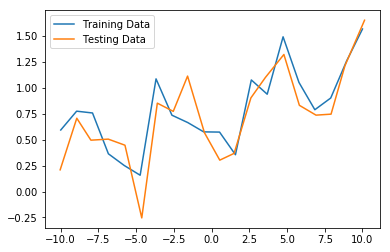

In [10]:
plt.plot(X, T, label='Training Data')
plt.plot(Xtest, Ttest, label='Testing Data')
plt.legend();

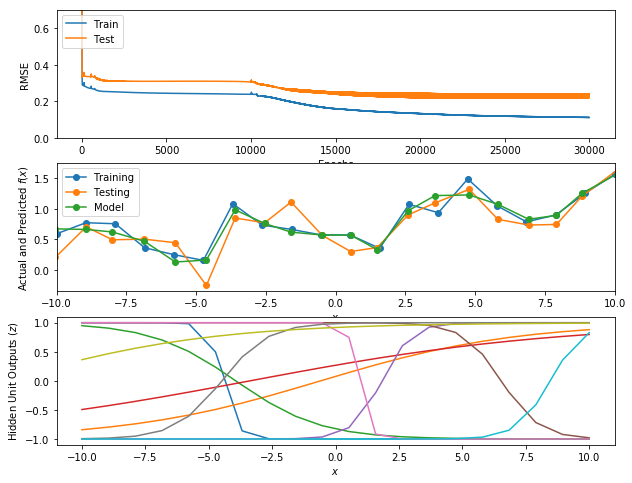

In [11]:
# Set parameters of neural network
nHiddens = 10

rhoh = 0.5
rhoo = 0.1

rh = rhoh / (nSamples*nOutputs)
ro = rhoo / (nSamples*nOutputs)

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(1+1, nHiddens))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+nHiddens ,nOutputs))-0.5)

# Add constant column of 1's
def addOnes(A):
    return np.insert(A, 0, 1, axis=1)

X1 = addOnes(X)
Xtest1 = addOnes(Xtest)

# Take nSteps steepest descent steps in gradient descent search in mean-squared-error function
nSteps = 30000

# collect training and testing errors for plotting
errorTrace = np.zeros((nSteps, 2))

fig = plt.figure(figsize=(10 ,8))

for step in range(nSteps):

    # Forward pass on training data
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W

    # Error in output
    error = T - Y

    # Backward pass - the backpropagation and weight update steps
    V = V + rh * X1.T @ ( ( error @ W[1:,:].T) * (1-Z**2))
    W = W + ro * Z1.T @ error

    # error traces for plotting
    errorTrace[step,0] = np.sqrt(np.mean((error**2)))
    
    Ytest = addOnes(np.tanh(Xtest1 @ V)) @ W  #!! Forward pass in one line
    errorTrace[step,1] = np.sqrt(np.mean((Ytest-Ttest)**2))

    if step % 1000 == 0 or step == nSteps-1:
        plt.clf()
        
        # Plot the trace of the mean squared error on training and testing data
        plt.subplot(3, 1, 1)
        plt.plot(errorTrace[:step, :])
        plt.ylim(0, 0.7)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend(('Train','Test'), loc='upper left')
        
        # Plot the training and testing data, and 
        # the output of our neural network model on the test data
        plt.subplot(3, 1, 2)
        plt.plot(X, T, 'o-', Xtest, Ttest, 'o-', Xtest, Ytest, 'o-')
        plt.xlim(-10, 10)
        plt.legend(('Training','Testing','Model'), loc='upper left')
        plt.xlabel('$x$')
        plt.ylabel('Actual and Predicted $f(x)$')
        
        # Plot the output of the hidden layer for each training sample
        plt.subplot(3, 1, 3)
        plt.plot(X, Z)
        plt.ylim(-1.1, 1.1)
        plt.xlabel('$x$')
        plt.ylabel('Hidden Unit Outputs ($z$)');
        
        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)

## Scaled Conjugate Gradient Algorithm

### The Scaled Part

The first derivative of an error function with respect to the
parameters of your model tells you which direction in the parameter
space to proceed to reduce the error function.  But how far do you go?
So far we have just taken a small step by subtracting a small constant
times the derivative from our current parameter values.

If we are in the vicinity of a minimum of the error function, we could
do what Newton did...approximate the function at the current parameter
value with a parabola and solve for the minimum of the parabola.  Use
this as the next guess at a good parameter value.  If the error
function is quadratic in the parameter, then we jump to the true
minimum immediately.

How would you fit a parabola to a function at a particular value of
$x$?  We can derive a way to do this using a truncated Taylor series
(google that) to approximate the function about a value of $x$:

$$
f(x+\Delta x) \approx \hat{f}(x+\Delta x) = f(x) + f'(x) \Delta x + \frac{1}{2} f''(x) \Delta x^2
+ \cdots
$$

Now we want to know what value of $\Delta x$ minimizes
$\hat{f}(x+\Delta x)$.  So take its derivative and set equal to zero.

$$
\begin{align*}
\frac{d \hat{f}(x+\Delta x)}{d\Delta x} &= f'(x) + \frac{1}{2} 2 f''(x)
\Delta x\\
& = f'(x) + f''(x) \Delta x
\end{align*}
$$

Setting equal to zero we get

$$
\begin{align*}
0 &= f'(x) + f''(x) \Delta x\\
\Delta x &= -\frac{f'(x)}{f''(x)}
\end{align*}
$$

Now we can update our guess for $x$ by adding $\Delta x$ to it.  Then,
fit a new parabola at the new value of $x$, calculate $\Delta x$, and
update $x$ again.  Actually, the last equation above does the parabola
approximation and calculation of $\Delta x$.

Here is a simple example.  Say we want to find the minimum of

$$
f(x) = 2 x^4 + 3 x^3 + 3
$$
To calculate

$$
\begin{align*}
\Delta x &= -\frac{f'(x)}{f''(x)}
\end{align*}
$$

we need the function's first and second derivatives.  The are

$$
\begin{align*}
f'(x) &= 8 x^3 + 9 x^2\\
f''(x) &= 24 x^2 + 18 x
\end{align*}
$$

All together now, in python!

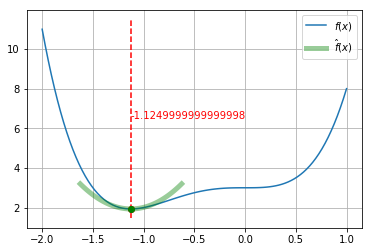

In [12]:
def f(x):
    return 2 * x**4 + 3 * x**3 + 3

def df(x): 
    return 8 * x**3 + 9 * x**2

def ddf(x):
    return 24 * x**2 + 18*x

x = -2  # our initial guess
def taylorf(x,dx):
    return f(x) + df(x) * dx + 0.5 * ddf(x) * dx**2

x = -2  # first guess at minimum

xs = np.linspace(-2,1,num=100)

fig = plt.figure()

dxs = np.linspace(-0.5,0.5,num=100)

for rep in range(10):
    time.sleep(2) # sleep 2 seconds
    plt.clf()
    plt.plot(xs,f(xs))
    plt.grid('on')
    plt.plot(x+dxs, taylorf(x,dxs),'g-',linewidth=5,alpha=0.4)
    plt.plot(x,f(x),'ro')         
    y0,y1 = plt.ylim()
    plt.plot([x,x],[y0,y1],'r--')
    
    x = x - df(x) / float(ddf(x))
    plt.plot(x,f(x),'go')
    plt.text(x,(y0+y1)*0.5,str(x),color='r')
    plt.legend(('$f(x)$','$\hat{f}(x)$'))
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

This approach quickly jumps to the nearby minimum of this function of one variable.  But, a neural network is parameterized by many variables, the weights.  So, in addition to using Newton's brain, we need an efficient way to steer our descent through the high-dimensional space of weights.  We need something better than just steepest descent in the direction of the current negative gradient.

For this, we will use a conjugate gradient method.  This will not be covered here, but you can read about it online at places like the [Wikipedia entry on conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method).  Let's just download an implementation of an optimization algorithm we will use, that combines Newton's approach for scaling the step size with conjugate gradients.  We will use the Scaled Conjugate Gradient (SCG) algorithm,
[Efficient
Training of Feed-Forward Neural Networks, by Moller](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.50.8063&rep=rep1&type=pdf).

In [13]:
!wget http://www.cs.colostate.edu/~anderson/cs440/notebooks/scg.tar

--2017-12-08 16:18:23--  http://www.cs.colostate.edu/~anderson/cs440/notebooks/scg.tar
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30720 (30K) [application/x-tar]
Saving to: ‘scg.tar.1’

scg.tar.1           100%[===================>]  30.00K  --.-KB/s    in 0.04s   

2017-12-08 16:18:23 (857 KB/s) - ‘scg.tar.1’ saved [30720/30720]



In [14]:
!tar xvf scg.tar

scaledconjugategradient.py
mlutils.py


Now let's see how minimization of a function using scaled conjugate gradient compares to just doing steepest descent.

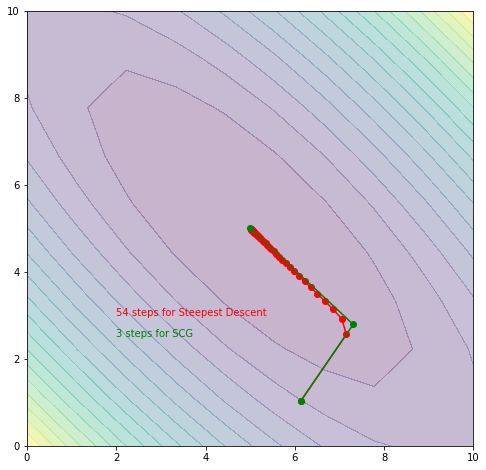

In [15]:
import scaledconjugategradient as scg

def parabola(x,xmin,s):
    d = x - xmin
    return np.dot(np.dot(d,S),d.T)

def parabolaGrad(x,xmin,s):
    d = x - xmin
    return 2 * np.dot(s,d)

f = parabola
df = parabolaGrad
center = np.array([5,5])
S = np.array([[5,4],[4,5]])

n = 10
xs = np.linspace(0,10,n)
ys = np.linspace(0,10,n)
X,Y = np.meshgrid(xs,ys)
both = np.vstack((X.flat,Y.flat)).T
nall = n*n
Z = np.zeros(nall)
for i in range(n*n):
    Z[i] = parabola(both[i,:],center,S)
Z.resize((n,n))

fig = plt.figure(figsize=(8,8))

for reps in range(10):
    time.sleep(2)
    
    firstx = np.random.uniform(0,10,2)
    
    # -------------------HERE ARE OUR TWO ALGORITHMS

    resultSCG = scg.scg(firstx, f, df, center, S, xPrecision=0.001, xtracep=True)
    resultSteepest =  scg.steepest(firstx, f, df, center, S, stepsize=0.05, xPrecision=0.001, xtracep=True)

    # -------------------
    
    plt.clf()
    plt.contourf(X, Y, Z, 20, alpha=0.3)
    plt.axis('tight')
    
    xt = resultSteepest['xtrace']
    plt.plot(xt[:, 0], xt[:, 1], 'ro-')

    xt = resultSCG['xtrace']
    plt.plot(xt[:, 0], xt[:, 1], 'go-')

    plt.text(2, 3, "%s steps for Steepest Descent" % resultSteepest['xtrace'].shape[0], color='red')
    plt.text(2, 2.5, "%s steps for SCG" % resultSCG['xtrace'].shape[0], color='green')
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True) 

Rosenbrock's function is often used to test optimization algorithms.
It is

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

In [16]:
def rosen(x):
    v = 100 * ((x[1] - x[0]**2)**2) + (1.0 - x[0])**2
    return v

def rosenGrad(x):
    g1 = -400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0])
    g2 =  200 * (x[1] - x[0]**2)
    return np.array([g1, g2])

f = rosen
df = rosenGrad

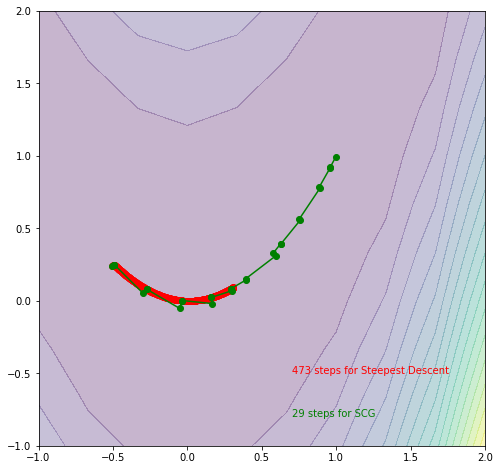

In [17]:
n = 10
xmin, xmax = -1,2
xs = np.linspace(xmin, xmax, n)
ys = np.linspace(xmin, xmax, n)
X, Y = np.meshgrid(xs, ys)
both = np.vstack((X.flat, Y.flat)).T
nall = n * n
Z = np.zeros(nall)
for i in range(n * n):
    Z[i] = f(both[i, :])
Z.resize((n, n))

fig = plt.figure(figsize=(8, 8))

for reps in range(10):
    time.sleep(2)
    
    firstx = np.random.uniform(xmin, xmax, 2)

    resultSCG = scg.scg(firstx, f, df, xPrecision=0.001, xtracep=True)
    resultSteepest =  scg.steepest(firstx, f, df, stepsize=0.001, xPrecision=0.001, xtracep=True)

    plt.clf()
    plt.contourf(X, Y, Z, 20, alpha=0.3)
    plt.axis('tight')
    
    xt = resultSteepest['xtrace']
    plt.plot(xt[: ,0], xt[:, 1], 'ro-')

    xt = resultSCG['xtrace']
    plt.plot(xt[:, 0], xt[:, 1], 'go-')

    plt.text(0.7, -0.5, "%s steps for Steepest Descent" % resultSteepest['nIterations'], color='red')
    plt.text(0.7, -0.8, "%s steps for SCG" % resultSCG['nIterations'], color='green')
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True) 

Only difficulty is that our *scg* (and *steepest*) implementation
requires all parameters to be concatenated in a single vector.  We
will use *pack* and *unpack* functions to concatentate and extract
$V$ and $W$ matrices.

Here is our example from earlier, but now using our
*ScaledConjugateGradient* module.

In [18]:
# Make some training data
n = 20
X = np.linspace(0., 20.0, n).reshape((n, 1))
T = 0.2 + 0.05 * X + 0.4 * np.sin(X) + 0.2 * np.random.normal(size=(n, 1))

# Make some testing data
Xtest = X + 0.1 * np.random.normal(size=(n, 1))
Ttest = 0.2 + 0.05 * X + 0.4 * np.sin(Xtest) + 0.2 * np.random.normal(size=(n, 1))

def addOnes(A):
    return np.insert(A, 0, 1, axis=1)

In [19]:
# Set parameters of neural network
nInputs = X.shape[1]
nHiddens = 10
nOutputs = T.shape[1]

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(nInputs+1, nHiddens))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+nHiddens, nOutputs))-0.5)

X1 = addOnes(X)
Xtest1 = addOnes(Xtest)

### gradientDescent functions require all parameters in a vector.
def pack(V, W):
    return np.hstack((V.flat, W.flat))

def unpack(w):
    '''Assumes V, W, nInputs, nHidden, nOuputs are defined in calling context'''
    V[:] = w[:(nInputs+1)*nHiddens].reshape((nInputs+1, nHiddens))
    W[:] = w[(nInputs+1)*nHiddens:].reshape((nHiddens+1, nOutputs))

In [20]:
### Function f to be minimized
def errorFunction(w):
    unpack(w)
    # Forward pass on training data
    Y = addOnes(np.tanh(X1 @ V)) @ W
    return np.mean((T - Y)**2)

In [21]:
### Gradient of f with respect to V,W
def errorGradient(w):
    unpack(w)
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W
    nSamples = X1.shape[0]
    nOutputs = T.shape[1]
    error = -(T - Y) / (nSamples*nOutputs)
    dV = 2 * X1.T @ (error @ W[1:,:].T * (1-Z**2))
    dW = 2 * Z1.T @ error
    return pack(dV,dW)

Now, finally, we can initialize weights to small random values and use scg to find best weights that minimize mean squared error.

In [22]:
# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(nInputs+1, nHiddens))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+nHiddens, nOutputs))-0.5)

result = scg.scg(pack(V, W), errorFunction, errorGradient,
                        nIterations = 10000,
                        ftracep = True)
unpack(result['x'])  # copy best parameters into V and W
errorTrace = result['ftrace']
print('Ran for', len(errorTrace), 'iterations')

Ran for 10001 iterations


In [23]:
errorTrace[:10]

array([ 0.86687879,  0.19358992,  0.16301128,  0.16301128,  0.16301128,
        0.16301128,  0.15310901,  0.1439026 ,  0.13124617,  0.13035549])

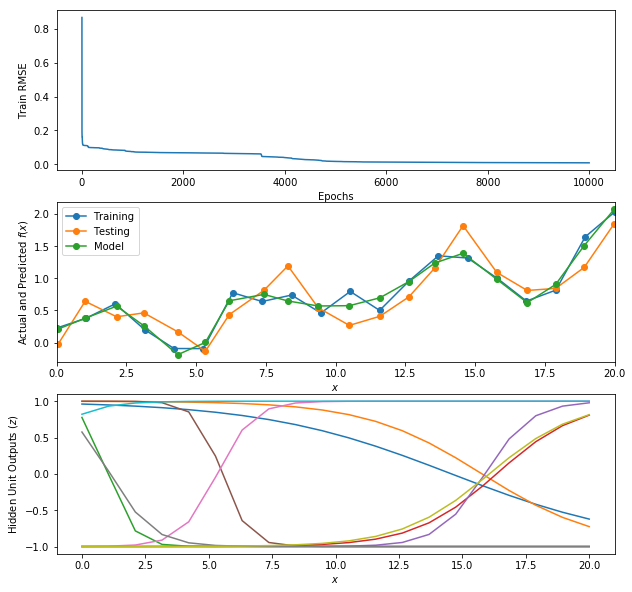

In [24]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(errorTrace)
nEpochs = len(errorTrace)
plt.xlim(0 - 0.05 * nEpochs, nEpochs * 1.05)
plt.xlabel('Epochs')
plt.ylabel('Train RMSE')

plt.subplot(3, 1, 2)
Y = addOnes(np.tanh(X1 @ V)) @ W 
Ytest = addOnes(np.tanh(Xtest1 @ V)) @ W
plt.plot(X, T, 'o-', Xtest, Ttest, 'o-', Xtest, Ytest, 'o-')
plt.xlim(0, 20)
plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
plt.xlabel('$x$')
plt.ylabel('Actual and Predicted $f(x)$')
        
plt.subplot(3, 1, 3)
Z = np.tanh(X1 @ V)
plt.plot(X, Z)
plt.xlabel('$x$')
plt.ylabel('Hidden Unit Outputs ($z$)');

## Neural Network Class

There is quite a bit of code here to keep track of.  Let's collect it into a class called `NeuralNetwork`.  First, let's discuss how it might be used. Make it as easy for the user as possible.

    X = ...
    T = ...
    nnet = NeuralNetWork(1, 5, 1)  # 1 input, 5 hidden units, 1 output
    nnet.train(X, T, nIterations=100)
    Y = nnet.use(X)
    
This implementation is for any number of hidden layers!

In [25]:
%%writefile neuralnetworks.py

import numpy as np
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
from copy import copy

class NeuralNetwork:

    def __init__(self, ni, nhs, no):        
        try:
            nihs = [ni] + list(nhs)
        except:
            nihs = [ni] + [nhs]
            nhs = [nhs]
        self.Vs = [1/np.sqrt(nihs[i]) *
                   np.random.uniform(-1, 1, size=(1+nihs[i], nihs[i+1])) for i in range(len(nihs)-1)]
        self.W = 1/np.sqrt(nhs[-1]) * np.random.uniform(-1, 1, size=(1+nhs[-1], no))
        self.ni, self.nhs, self.no = ni, nhs, no
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.trained = False
        self.reason = None
        self.errorTrace = None
        self.numberOfIterations = None

    def __repr__(self):
        str = 'NeuralNetwork({}, {}, {})'.format(self.ni, self.nhs, self.no)
        # str += '  Standardization parameters' + (' not' if self.Xmeans == None else '') + ' calculated.'
        if self.trained:
            str += '\n   Network was trained for {} iterations. Final error is {}.'.format(self.numberOfIterations,
                                                                                           self.errorTrace[-1])
        else:
            str += '  Network is not trained.'
        return str
            
    def standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result
    
    def unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans
    
    def standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result
    
    def unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans
   
    def pack(self, Vs, W):
        return np.hstack([V.flat for V in Vs] + [W.flat])

    def unpack(self,w):
        first = 0
        numInThisLayer = self.ni
        for i in range(len(self.Vs)):
            self.Vs[i][:] = w[first:first+(numInThisLayer+1)*self.nhs[i]].reshape((numInThisLayer+1, self.nhs[i]))
            first += (numInThisLayer+1) * self.nhs[i]
            numInThisLayer = self.nhs[i]
        self.W[:] = w[first:].reshape((numInThisLayer+1, self.no))

    def train(self, X, T, nIterations=100, verbose=False, weightPrecision=0, errorPrecision=0, saveWeightsHistory=False):
        
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
        X = self.standardizeX(X)

        if T.ndim == 1:
            T = T.reshape((-1,1))

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        T = self.standardizeT(T)

        def objectiveF(w):
            self.unpack(w)
            Zprev = X
            for i in range(len(self.nhs)):
                V = self.Vs[i]
                Zprev = np.tanh(Zprev @ V[1:,:] + V[0:1,:])  # handling bias weight without adding column of 1's
            Y = Zprev @ self.W[1:,:] + self.W[0:1,:]
            return np.mean((T-Y)**2)

        def gradF(w):
            self.unpack(w)
            Zprev = X
            Z = [Zprev]
            for i in range(len(self.nhs)):
                V = self.Vs[i]
                Zprev = np.tanh(Zprev @ V[1:,:] + V[0:1,:])
                Z.append(Zprev)
            Y = Zprev @ self.W[1:,:] + self.W[0:1,:]
            delta = -(T - Y) / (X.shape[0] * T.shape[1])
            dW = 2 * np.vstack(( np.ones((1,delta.shape[0])) @ delta, 
                                 Z[-1].T @ delta ))
            dVs = []
            delta = (1 - Z[-1]**2) * (delta @ self.W[1:,:].T)
            for Zi in range(len(self.nhs), 0, -1):
                Vi = Zi - 1 # because X is first element of Z
                dV = 2 * np.vstack(( np.ones((1,delta.shape[0])) @ delta,
                                     Z[Zi-1].T @ delta ))
                dVs.insert(0,dV)
                delta = (delta @ self.Vs[Vi][1:,:].T) * (1 - Z[Zi-1]**2)
            return self.pack(dVs, dW)

        scgresult = scg.scg(self.pack(self.Vs, self.W), objectiveF, gradF,
                            xPrecision = weightPrecision,
                            fPrecision = errorPrecision,
                            nIterations = nIterations,
                            verbose=verbose,
                            ftracep=True,
                            xtracep=saveWeightsHistory)

        self.unpack(scgresult['x'])
        self.reason = scgresult['reason']
        self.errorTrace = np.sqrt(scgresult['ftrace']) # * self.Tstds # to unstandardize the MSEs
        self.numberOfIterations = len(self.errorTrace)
        self.trained = True
        self.weightsHistory = scgresult['xtrace'] if saveWeightsHistory else None
        return self

    def use(self, X, allOutputs=False):
        Zprev = self.standardizeX(X)
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = np.tanh( Zprev @ V[1:,:] + V[0:1,:])
            Z.append(Zprev)
        Y = Zprev @ self.W[1:,:] + self.W[0:1,:]
        Y = self.unstandardizeT(Y)
        return (Y, Z[1:]) if allOutputs else Y

    def getNumberOfIterations(self):
        return self.numberOfIterations
    
    def getErrors(self):
        return self.errorTrace
        
    def getWeightsHistory(self):
        return self.weightsHistory
        
    def draw(self, inputNames = None, outputNames = None):
        ml.draw(self.Vs, self.W, inputNames, outputNames)

Overwriting neuralnetworks.py


If the above class definition is placed in a file named *neuralnetworks.py*, then an instance of this class can be instantiated using code like

    import neuralnetworks as nn
    nnet = nn.NeuralNetwork(1,4,1)
    
The files *scaledconjugategradient.py* and *mlutils.py* must be in your working directory.

SCG stopped after 1001 iterations: did not converge
Final RMSE: train 0.0615553218382 test 3.21151553417


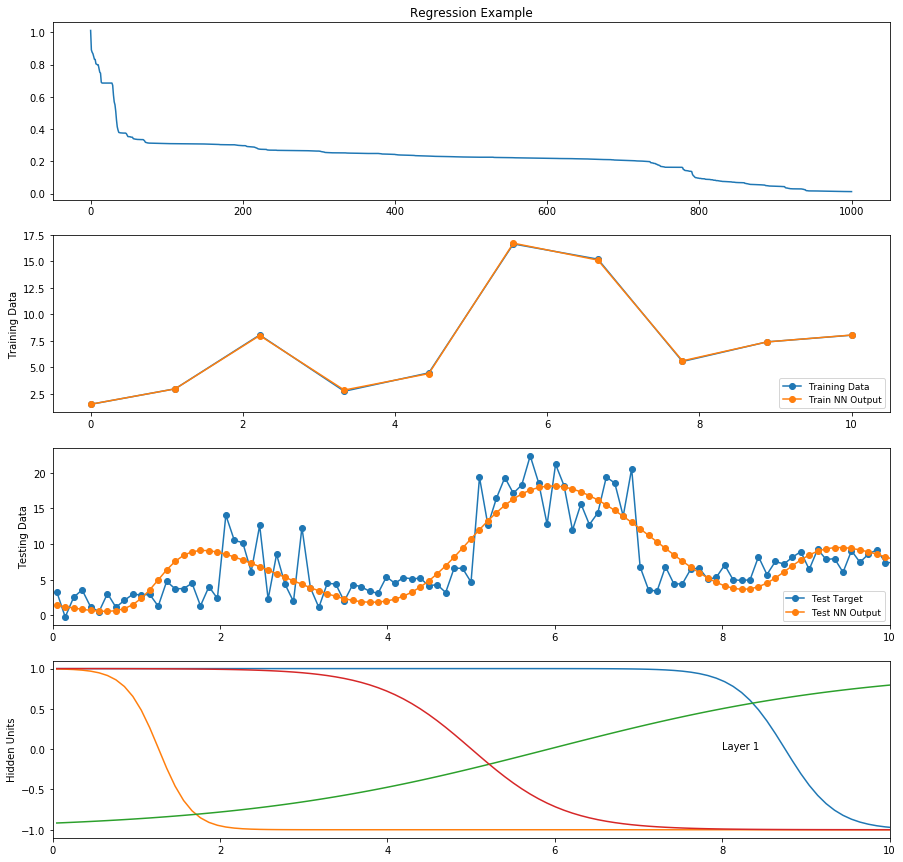

In [26]:
import neuralnetworks as nn
# import imp
# imp.reload(nn)

nSamples = 10
X = np.linspace(0, 10, nSamples).reshape((-1, 1))
T = 1.5 + 0.6 * X + 0.8 * np.sin(1.5*X)
T[np.logical_and(X > 2, X < 3)] *= 3
T[np.logical_and(X > 5, X < 7)] *= 3

nSamples = 100
Xtest = np.linspace(0, 10, nSamples).reshape((-1, 1)) + 10.0/nSamples/2
Ttest = 1.5 + 0.6 * Xtest + 0.8 * np.sin(1.5*Xtest) + np.random.uniform(-2, 2, size=(nSamples, 1))
Ttest[np.logical_and(Xtest > 2, Xtest < 3)] *= 3
Ttest[np.logical_and(Xtest > 5, Xtest < 7)] *= 3

nnet = nn.NeuralNetwork(1, 4, 1)

nnet.train(X, T, errorPrecision=1.e-10, weightPrecision=1.e-10, nIterations=1000)
print("SCG stopped after", nnet.getNumberOfIterations(), "iterations:", nnet.reason)
Y = nnet.use(X)
Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)), "test", np.sqrt(np.mean((Ytest-Ttest)**2)))

plt.figure(figsize=(15, 15))

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

plt.subplot(nPlotRows, 1, 1)
plt.plot(nnet.getErrors())
plt.title('Regression Example')

plt.subplot(nPlotRows, 1, 2)
plt.plot(X, T, 'o-', label='Training Data')
plt.plot(X, Y, 'o-', label='Train NN Output')
plt.ylabel('Training Data')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(nPlotRows, 1, 3)
plt.plot(Xtest, Ttest, 'o-', label='Test Target')
plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')
plt.ylabel('Testing Data')
plt.xlim(0, 10)
plt.legend(loc='lower right', prop={'size':9})
for i in range(nHLayers):
    layer = nHLayers - i - 1
    plt.subplot(nPlotRows, 1, i+4)
    plt.plot(Xtest, Ztest[layer])
    plt.xlim(0,10)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Hidden Units')
    plt.text(8,0, 'Layer {}'.format(layer+1))

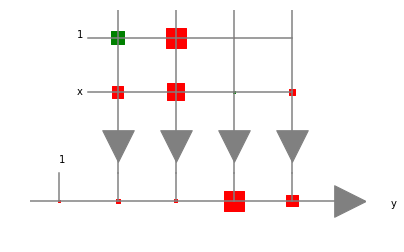

In [27]:
nnet.draw(['x'],['y'])

What happens if we add another two hidden layers, for a total of three hidden layers?  Let's use 5 units in each hidden layer.

In [28]:
nnet = nn.NeuralNetwork(1, (5, 5), 1)

The rest of the code is the same.  Even the plotting code written above works for as many hidden layers as we create.

SCG stopped after 1001 iterations: did not converge
Final RMSE: train 7.59127672256e-13 test 3.12983001381


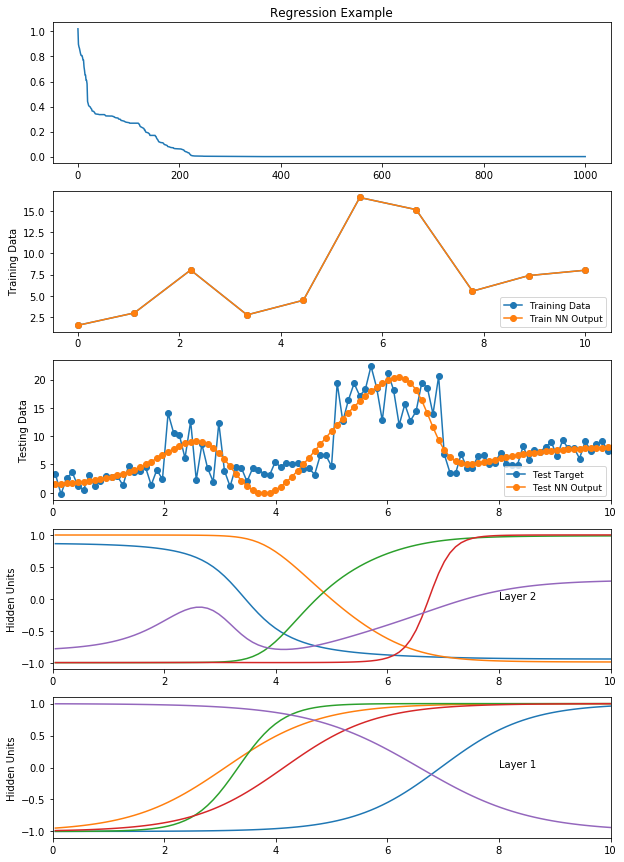

In [29]:
nnet.train(X, T, nIterations=1000) # precision not included, so defaults of zero used, which means will not terminate early
print("SCG stopped after", nnet.getNumberOfIterations(), "iterations:", nnet.reason)
Y = nnet.use(X)
Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)),"test", np.sqrt(np.mean((Ytest-Ttest)**2)))

plt.figure(figsize=(10, 15))

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

plt.subplot(nPlotRows, 1, 1)
plt.plot(nnet.getErrors())
plt.title('Regression Example')

plt.subplot(nPlotRows, 1, 2)
plt.plot(X, T, 'o-', label='Training Data')
plt.plot(X, Y, 'o-', label='Train NN Output')
plt.ylabel('Training Data')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(nPlotRows, 1, 3)
plt.plot(Xtest, Ttest, 'o-', label='Test Target')
plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')
plt.ylabel('Testing Data')
plt.xlim(0, 10)
plt.legend(loc='lower right', prop={'size':9})
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nPlotRows, 1, i+4)
    plt.plot(Xtest, Ztest[layer])
    plt.xlim(0, 10)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('Hidden Units')
    plt.text(8, 0, 'Layer {}'.format(layer+1))

For more fun, wrap the above code in a function to make it easy to try different network structures.

In [30]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )

    nnet.train(X, T, nIterations=nIterations, verbose=verbose)
    # print("SCG stopped after",nnet.getNumberOfIterations(),"iterations:",nnet.reason)
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    print("Final RMSE: train", np.sqrt(np.mean((Y-T)**2)), "test", np.sqrt(np.mean((Ytest-Ttest)**2)))

    plt.figure(figsize=(10, 15))
    nHLayers = len(nnet.nhs)
    nPlotRows = 3 + nHLayers

    plt.subplot(nPlotRows, 1, 1)
    plt.plot(nnet.getErrors())
    plt.title('Regression Example')

    plt.subplot(nPlotRows, 1, 2)
    plt.plot(X, T, 'o-', label='Training Data')
    plt.plot(X, Y, 'o-', label='Train NN Output')
    plt.ylabel('Training Data')
    plt.legend(loc='lower right', prop={'size':9})

    plt.subplot(nPlotRows, 1, 3)
    plt.plot(Xtest, Ttest, 'o-', label='Test Target')
    plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')
    plt.ylabel('Testing Data')
    plt.xlim(0, 10)
    plt.legend(loc='lower right', prop={'size':9})
    for i in range(nHLayers):
        layer = nHLayers-i-1
        plt.subplot(nPlotRows, 1, i+4)
        plt.plot(Xtest, Ztest[layer])
        plt.xlim(0, 10)
        plt.ylim(-1.1, 1.1)
        plt.ylabel('Hidden Units')
        plt.text(8, 0, 'Layer {}'.format(layer+1))
    return nnet

Final RMSE: train 1.34317887603 test 9.93498966455


NeuralNetwork(1, (2, 2), 1)
   Network was trained for 1001 iterations. Final error is 0.27716614736475775.

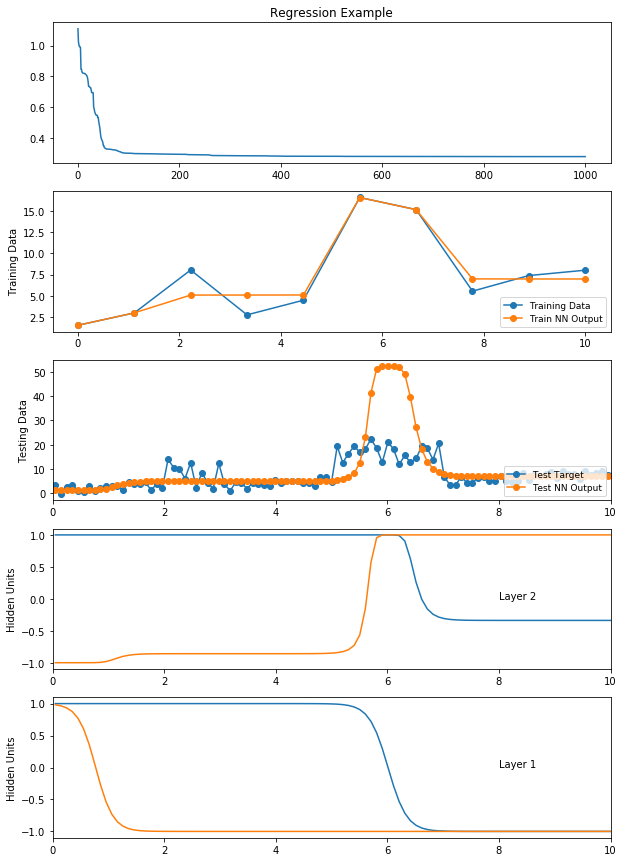

In [31]:
run(X, T, (2, 2), nIterations=1000)

Final RMSE: train 1.58522796776 test 3.76051354589


NeuralNetwork(1, (2, 2, 2, 2), 1)
   Network was trained for 1001 iterations. Final error is 0.3271131912205233.

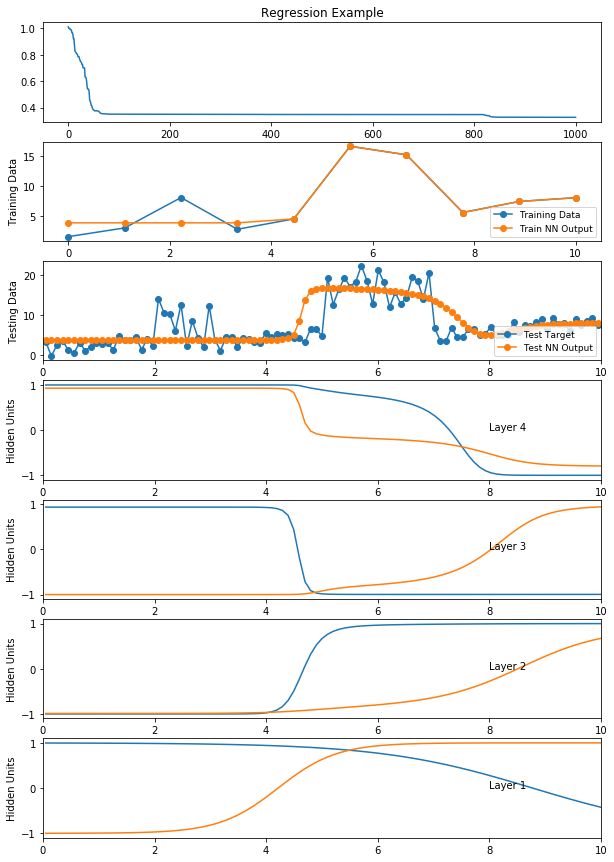

In [32]:
run(X, T, (2, 2, 2, 2), nIterations=1000)

In [33]:
[2]*6

[2, 2, 2, 2, 2, 2]

Final RMSE: train 0.00115048971156 test 2.95637285492


NeuralNetwork(1, [2, 2, 2, 2, 2, 2], 1)
   Network was trained for 4001 iterations. Final error is 0.00023740456809264907.

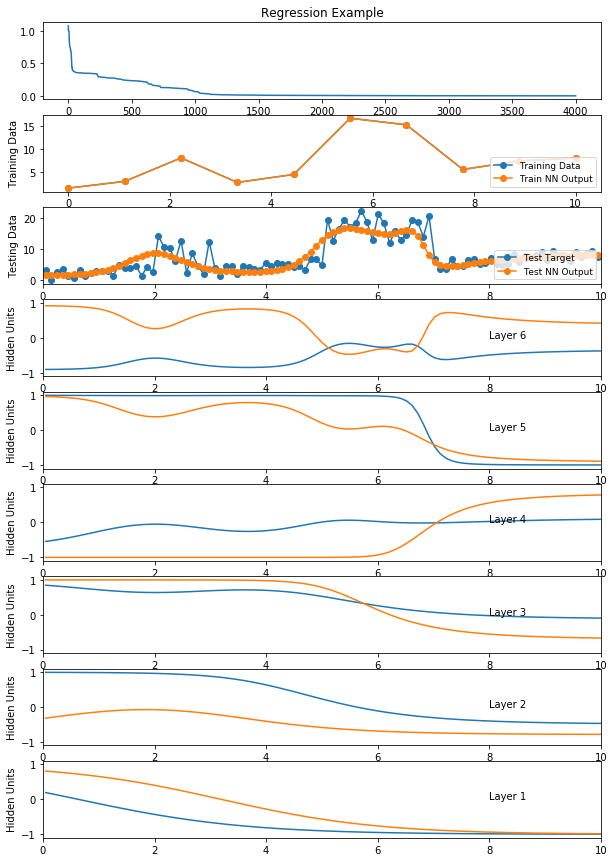

In [34]:
run(X, T, [2]*6, nIterations=4000)

Can you say "deep learning"?

This last example doesn't always work.  Depends a lot on good initial random weight values. Go back to the above cell and run it again and again, until you see it not work.

SCG: Iteration 100 fValue Eval 0.0239954365211 Scale 0.000334477614735
SCG: Iteration 200 fValue Eval 4.2115736719e-05 Scale 1e-15
SCG: Iteration 300 fValue Eval 1.43233898372e-13 Scale 1e-15
SCG: Iteration 400 fValue Eval 1.27258997674e-22 Scale 1e-15
SCG: Iteration 500 fValue Eval 2.45255611764e-27 Scale 6.7108864e-08
SCG: Iteration 600 fValue Eval 2.44534042851e-27 Scale 1e+20
SCG: Iteration 700 fValue Eval 2.44534042851e-27 Scale 1e+20
SCG: Iteration 800 fValue Eval 2.44534042851e-27 Scale 1e+20
SCG: Iteration 900 fValue Eval 2.44534042851e-27 Scale 1e+20
SCG: Iteration 1000 fValue Eval 2.44534042851e-27 Scale 1e+20
Final RMSE: train 2.39815944754e-13 test 2.89778733335


NeuralNetwork(1, [50, 10, 3, 1, 3, 10, 50], 1)
   Network was trained for 1001 iterations. Final error is 4.945038350215162e-14.

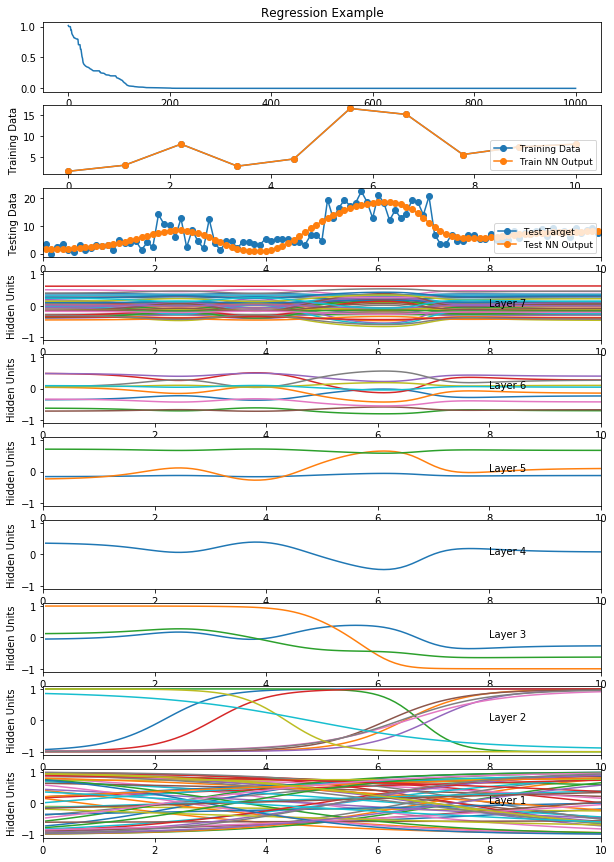

In [35]:
nnet = run(X, T, [50,10,3,1,3,10,50], nIterations=1000, verbose=True)
nnet

Run the above cell several times to see very different solutions as observed in the pattern of hidden layer outputs.

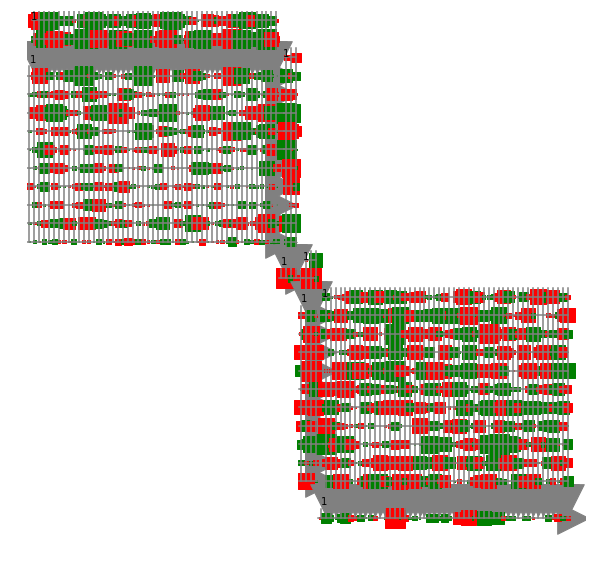

In [36]:
plt.figure(figsize=(10, 10))
nnet.draw()

Let's try saving the weights after each iteration and then make a movie showing how the outputs of each layer change as the network is trained.

In [37]:
def run(X, T, hiddenUnits, nIterations=100, verbose=False, saveWeightsHistory=False):
    if X.shape[1] != 1 or T.shape[1] != 1:
        print('This function written for one-dimensional input samples, X, and one-dimensional targets, T.')
        return
    nnet = nn.NeuralNetwork(1, hiddenUnits,1 )
    nnet.train(X, T, nIterations=nIterations, verbose=verbose, saveWeightsHistory=saveWeightsHistory)
    return nnet

In [38]:
startTime = time.time()
nnet = run(X, T, [50,10,3,1,3,10,50], nIterations=500, verbose=True, saveWeightsHistory=True)
print('Training took',time.time()-startTime,'seconds')
nnet

SCG: Iteration 50 fValue Eval 0.53278399857 Scale 5.92339028837e-05
SCG: Iteration 100 fValue Eval 0.291148843304 Scale 2.79863495756
SCG: Iteration 150 fValue Eval 0.118649703886 Scale 1.16369063406e-14
SCG: Iteration 200 fValue Eval 0.0962832381441 Scale 0.0127949138329
SCG: Iteration 250 fValue Eval 0.0426270127002 Scale 4.65476253626e-14
SCG: Iteration 300 fValue Eval 0.025941478248 Scale 0.000137438953472
SCG: Iteration 350 fValue Eval 0.0132303019325 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0110530730873 Scale 4.294967296e-06
SCG: Iteration 450 fValue Eval 0.00154345048824 Scale 2e-15
SCG: Iteration 500 fValue Eval 0.000433197392771 Scale 1e-15
Training took 1.3125319480895996 seconds


NeuralNetwork(1, [50, 10, 3, 1, 3, 10, 50], 1)
   Network was trained for 501 iterations. Final error is 0.02081339455186202.

In [39]:
startTime = time.time()
nnet = run(X, T, [20, 10, 5, 2], nIterations=500, verbose=True, saveWeightsHistory=True)
print('Training took',time.time()-startTime,'seconds')
nnet

SCG: Iteration 50 fValue Eval 0.120063092121 Scale 5.65626572448e-05
SCG: Iteration 100 fValue Eval 0.082796712293 Scale 0.00011312531449
SCG: Iteration 150 fValue Eval 0.0473289151998 Scale 8.63077655712e-10
SCG: Iteration 200 fValue Eval 4.91581148561e-05 Scale 1e-15
SCG: Iteration 250 fValue Eval 8.56396011534e-07 Scale 1e-15
SCG: Iteration 300 fValue Eval 9.07425937174e-10 Scale 1e-15
SCG: Iteration 350 fValue Eval 5.86076938736e-12 Scale 1e-15
SCG: Iteration 400 fValue Eval 4.30762931246e-23 Scale 1e-15
SCG: Iteration 450 fValue Eval 2.30061973544e-27 Scale 1.6384e-11
SCG: Iteration 500 fValue Eval 2.25297168935e-27 Scale 158456325028528.7
Training took 0.8188116550445557 seconds


NeuralNetwork(1, [20, 10, 5, 2], 1)
   Network was trained for 501 iterations. Final error is 4.746547892262196e-14.

In [40]:
from matplotlib import animation
import matplotlib # for next statement
matplotlib.rc('animation', html='html5')
# matplotlib.rc('animation', html='none')

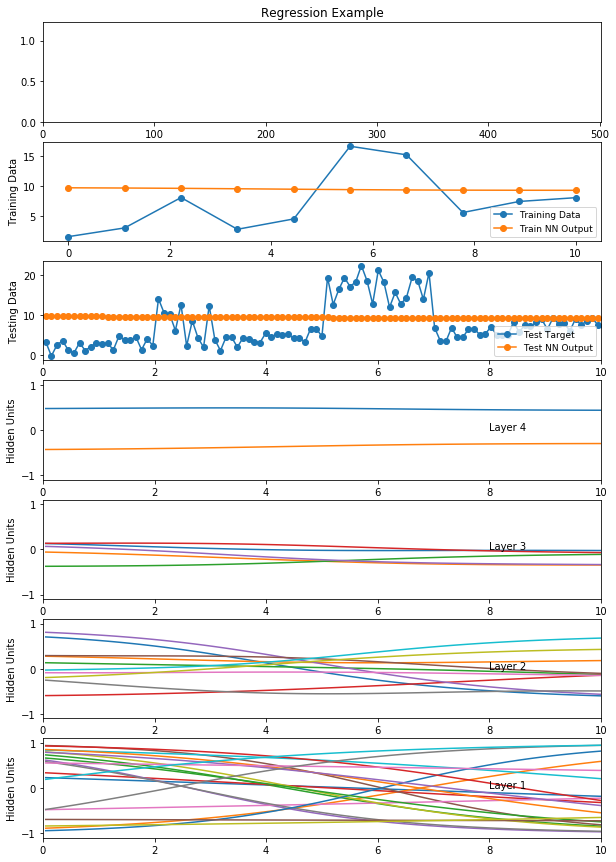

In [41]:
weightsHistory = nnet.getWeightsHistory()
nnet.unpack(weightsHistory[0,:])
Y = nnet.use(X)
Ytest, Ztest = nnet.use(Xtest, allOutputs=True)

nHLayers = len(nnet.nhs)
nPlotRows = 3 + nHLayers

fig = plt.figure(figsize=(10, 15))
plt.subplot(nPlotRows, 1, 1)
errors = nnet.getErrors()
errorsLine = plt.plot(0,errors[0])[0]
plt.xlim(0,len(errors))
plt.ylim(0,np.max(errors)*1.1)

plt.title('Regression Example')

plt.subplot(nPlotRows, 1, 2)
plt.plot(X, T, 'o-', label='Training Data')
trainLine = plt.plot(X, Y, 'o-', label='Train NN Output')[0]
plt.ylabel('Training Data')
plt.legend(loc='lower right', prop={'size':9})

plt.subplot(nPlotRows, 1, 3)
plt.plot(Xtest, Ttest, 'o-', label='Test Target')
testLine = plt.plot(Xtest, Ytest, 'o-', label='Test NN Output')[0]
plt.ylabel('Testing Data')
plt.xlim(0, 10)
plt.legend(loc='lower right', prop={'size':9})
hiddenOutputLines = []
for i in range(nHLayers):
    layer = nHLayers-i-1
    plt.subplot(nPlotRows, 1, i+4)
    hiddenOutputLines.append( plt.plot(Xtest, Ztest[layer]) )
    plt.xlim(0, 10)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('Hidden Units')
    plt.text(8, 0, 'Layer {}'.format(layer+1))
    
updatesPerFrame = 2

def animator(framei):
    # print('frame',framei)
    step = framei * updatesPerFrame
    nnet.unpack(weightsHistory[step,:])
    Y = nnet.use(X)
    Ytest, Ztest = nnet.use(Xtest, allOutputs=True)
    errorsLine.set_data(range(step),errors[:step])

    trainLine.set_ydata(Y)
    testLine.set_ydata(Ytest)
    
    for iLayer in range(len(hiddenOutputLines)):
        HOLines = hiddenOutputLines[iLayer]
        Zlayer = Ztest[nHLayers - iLayer - 1]
        for iUnit in range(len(HOLines)):
            HOLines[iUnit].set_ydata(Zlayer[:,iUnit])
    return [errorsLine, trainLine, testLine] + hiddenOutputLines

In [42]:
nFrames = len(nnet.getErrors()) // updatesPerFrame # integer divide
anim = animation.FuncAnimation(fig, animator, frames=nFrames, interval=50, blit=False)

This next cell will take a while.  It is rendering the animation and will not display it until it has finished. It might take several minutes.

In [1]:
anim

NameError: name 'anim' is not defined